In [1]:
# using Pkg     ####use this if you are getting errors
# Pkg.instantiate()
using Revise, Xpress, JuMP, REopt, CSV, Plots, DataFrames, Statistics, JSON, StatsBase

┌ Info: Xpress: Found license file /Applications/FICO Xpress/Xpress Workbench.app/Contents/Resources/xpressmp/bin/xpauth.xpr
└ @ Xpress /Users/bpulluta/.julia/packages/Xpress/IPJtC/src/license.jl:44
┌ Info: Xpress: Development license detected.
└ @ Xpress /Users/bpulluta/.julia/packages/Xpress/IPJtC/src/license.jl:89


### Comments

-  1) add output of max and min fuel used
-  2) ensure that battery is charging generator to ensure more resilience
-  3) fuel accounting needs to be rethought, it doesn't make sense that we are leaving fuel to be unlimited since we have cost and limits on site associated with those variables. It might be better to program in fuel based on size of generator or max consumption
-  4) Maybe make generator size a variable of 10 and place ceiling
-  5) Output critical_loads 
-  6) increasing the gen size only slightly will cause it to be infeasible
-  7) Might be good to get the entire year survival stats rather than just a few to get a good idea of the probability throughout the year


## Code Begins

### Function to get key reopt results

In [2]:
function summarize_reopt_results(reopt_response)
    # Adjusting for the Financial details
    println("LCC (\$) = ", get(reopt_response["Financial"], "lcc", "N/A"))
    println("Capital Cost, Net (\$) = ", get(reopt_response["Financial"], "lifecycle_capital_costs", "N/A"))
    println("Lifecycle Emission Tons (CO2) = ", get(reopt_response["Site"], "lifecycle_emissions_tonnes_CO2", "N/A"))
    println("NPV (\$) = ", get(reopt_response["Financial"], "npv", "N/A"))
    println("LCOE (\$/kWh) = ", get(reopt_response["PV"], "lcoe_per_kwh", "N/A"))

    tech_list = ["PV", "Wind", "ElectricStorage", "CHP", "Generator", "HotThermalStorage",
        "ColdThermalStorage", "AbsorptionChiller", "GHP", "NewBoiler", "SteamTurbine"]

    for tech in tech_list
        if haskey(reopt_response, tech)
            if tech ==   "GHP"
                # Adjusting for GHP details
                println("GHX Number of Boreholes = ", get(reopt_response[tech]["ghpghx_chosen_outputs"], "number_of_boreholes", "N/A"))
                println("GHP Heat Pump Capacity (ton) = ", get(reopt_response[tech]["ghpghx_chosen_outputs"], "peak_combined_heatpump_thermal_ton", "N/A"))
            end
            # Extract sizes for each technology
            for (key, value) in reopt_response[tech]
                if occursin("size", key)
                    println("$(tech) $(key) = $(value)")
                end
            end
        end
    end
end

summarize_reopt_results (generic function with 1 method)

### BASE CASE

In [3]:
# Load inputs for REopt optimization
p =   REoptInputs("./scenarios/reopt_inputs.json")

# Initialize the model
model    =   Model(Xpress.Optimizer)
modelbau =   Model(Xpress.Optimizer)

# Run the REopt optimization
results =   run_reopt([modelbau, model], p)

┌ REopt | Warn: When using stochastic outage modeling (i.e. outage_start_time_steps, outage_durations, outage_probabilities), 


│                     emissions and renewable energy percentage calculations and constraints do not consider outages.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/electric_utility.jl:199


┌ REopt | Info: Querying PVWatts for production factor and ambient air temperature... 
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/utils.jl:414


┌ REopt | Info: PVWatts success.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/utils.jl:420


┌ REopt | Warn: Adding binary variable to model outages. Some solvers are very slow with integer variables
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:642
┌ REopt | Info: 

Model built. Optimizing...
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:541


FICO Xpress v8.12.3, Hyper, solve started 16:09:37, Sep 14, 2023
Heap usage: 5043KB (peak 5043KB, 559KB system)
Minimizing MILP  with these control settings:
OUTPUTLOG = 1
MPSNAMELENGTH = 64
CALLBACKFROMMASTERTHREAD = 1
Original problem has:
     19541 rows        11306 cols        28805 elements      1009 globals
         1 inds
Presolved problem has:
         0 rows            0 cols            0 elements         0 globals
Presolve finished in 0 seconds
Heap usage: 5428KB (peak 16MB, 561KB system)
Will try to keep branch and bound tree memory usage below 29.5GB
Starting concurrent solve with dual

 Concurrent-Solve,   0s
            Dual        
    objective   dual inf
 D  152512.47   .0000000
------- optimal --------
Concurrent statistics:
      Dual: 0 simplex iterations, 0.00s
Optimal solution found
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       152512.4747      D      0     0        .000000     0
Dual solved problem
  0 simplex iterations in 0.0

 *** Search completed ***
Uncrunching matrix
Final MIP objective                   : 1.525124746625998e+05
Final MIP bound                       : 1.525124746625998e+05
  Solution time / primaldual integral :         0s/ 58.408434%
  Number of solutions found / nodes   :         1 /         1
  Max primal violation      (abs/rel) :       0.0 /       0.0
  Max integer violation     (abs    ) :       0.0


┌ REopt | Info: REopt solved with 


│   termination_status(m) = OPTIMAL
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:554
┌ REopt | Info: Solving took 3.24 seconds.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:555
┌ REopt | Info: 

Results processing took 1.989 seconds.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:560
┌ REopt | Warn: Adding binary variable to model gas generator. Some solvers are very slow with integer variables.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:607
┌ REopt | Warn: 

Adding binary variable to model outages. Some solvers are very slow with integer variables
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:642


┌ REopt | Info: Model built. Optimizing...
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:541


FICO Xpress v8.12.3, Hyper, solve started 16:09:51, Sep 14, 2023
Heap usage: 51MB (peak 51MB, 697KB system)
Minimizing MILP  with these control settings:
OUTPUTLOG = 1
MPSNAMELENGTH = 64
CALLBACKFROMMASTERTHREAD = 1
Original problem has:
    169815 rows       128229 cols       521396 elements      9771 globals
      3534 inds


Presolved problem has:
     53497 rows        31961 cols       211078 elements       507 globals
      2520 inds
Presolve finished in 0 seconds
Heap usage: 83MB (peak 184MB, 699KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.52e-05,  1.00e+06] / [ 3.52e-05,  1.25e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+09] / [ 1.07e-02,  1.00e+06]
  Objective      [min,max] : [ 1.00e-04,  1.14e+03] / [ 1.00e-04,  7.78e+02]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 28.4GB
Starting concurrent solve with dual, primal and barrier (8 threads)



                           Concurrent-Solve,   0s
            Dual                      Primal                     Barrier      
    objective   dual inf       objective   sum inf         p.obj.     d.obj.  
 D  101071.80   .0000000 |  p  14373070.  10218.868 |  B  1.772E+08 -9.599E+10
 D  110423.74   .0000000 |  p  200147.48   .0000000 |  B  333806.22  38830.430


 D  117949.04   .0000000 |  p  199244.12   .0000000 |  B  201882.68  190966.60


 D  156026.87   .0000000 |  p  199244.12   .0000000 |  B  197850.76  197846.94


----- interrupted ------ | ----- interrupted ------ | ------- optimal --------


Concurrent statistics:
      Dual: 14168 simplex iterations, 1.34s
    Primal: 7266 simplex iterations, 1.34s
   Barrier: 53 barrier and 1399 simplex iterations, 1.34s
            Barrier used 8 threads 8 cores, L1\L2 cache: 64K\4096K
            Barrier used SSE2 support, crossover used 8 threads
Optimal solution found
 
   Its         Obj Value      S   Ninf  Nneg        Sum Inf  Time
   102       197849.9254      P      0     0        .000000     2
Barrier solved problem
  53 barrier and 1399 simplex iterations in 1.36 seconds at time 2

Final objective                       : 1.978499253771025e+05
  Max primal violation      (abs/rel) : 1.776e-15 / 1.684e-15
  Max dual violation        (abs/rel) : 2.331e-15 / 2.331e-15
  Max complementarity viol. (abs/rel) :       0.0 /       0.0
High attention level predicted from matrix features

Starting root cutting & heuristics
 
 Its Type    BestSoln    BestBound   Sols    Add    Del     Gap     GInf   Time
c         197849.9254  197849.9254

 *** Search completed ***
Uncrunching matrix
Final MIP objective                   : 1.978499253770989e+05
Final MIP bound                       : 1.978499253771025e+05
  Solution time / primaldual integral :         2s/ 99.961458%
  Number of solutions found / nodes   :         1 /         1
  Max primal violation      (abs/rel) : 2.798e-13 / 2.798e-13
  Max integer violation     (abs    ) :       0.0


┌ REopt | Info: REopt solved with 
│   termination_status(m) = OPTIMAL
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:554
┌ REopt | Info: Solving took 2.949 seconds.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:555
┌ REopt | Info: 

Results processing took 4.881 seconds.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:560


Dict{String, Any} with 12 entries:
  "Site"            => Dict{String, Any}("annual_emissions_from_fuelburn_tonnes…
  "Generator"       => Dict{String, Any}("electric_to_grid_series_kw"=>1-dimens…
  "Outages"         => Dict{String, Any}("generator_fuel_used_per_outage_gal"=>…
  "ElectricStorage" => Dict{String, Any}("size_kw"=>3.76, "size_kwh"=>9.21, "in…
  "status"          => "optimal"
  "solver_seconds"  => 2.949
  "ElectricUtility" => Dict{String, Any}("lifecycle_emissions_tonnes_CO2_bau"=>…
  "ElectricTariff"  => Dict{String, Any}("lifecycle_demand_cost_after_tax_bau"=…
  "ElectricLoad"    => Dict{String, Any}("load_series_kw"=>Real[8.302, 8.285, 8…
  "Messages"        => Dict{Any, Any}("errors"=>Any[], "warnings"=>Any[("core_r…
  "PV"              => Dict{String, Any}("electric_to_grid_series_kw"=>[0.0, 0.…
  "Financial"       => Dict{String, Any}("lifecycle_chp_standby_cost_after_tax"…

In [4]:
open("./results/initial_reopt_results.json", "w") do f
    write(f, JSON.json(results))
end

700820

### SETTING UP RELIABILITY INPUTS BASED ON BASE CASE RESULTS


In [5]:
# Load reliability inputs from file
reliability_inputs =   JSON.parsefile("./scenarios/backup_reliability_inputs.json")

# Update reliability inputs based on the results from the base case
reliability_inputs["pv_size_kw"]                  =   results["PV"]["size_kw"]
reliability_inputs["critical_loads_kw"]           =   results["ElectricLoad"]["critical_load_series_kw"]
reliability_inputs["generator_size_kw"]           =   results["Generator"]["size_kw"]
reliability_inputs["battery_size_kw"]             =   results["ElectricStorage"]["size_kw"]
reliability_inputs["battery_size_kwh"]            =   results["ElectricStorage"]["size_kwh"]
reliability_inputs["pv_production_factor_series"] =   results["PV"]["production_factor_series"]
reliability_inputs["num_generators"]              =   1


1

### COMPUTE RELIABILITY METRICS


In [6]:
reliability_results =   backup_reliability(results, p, reliability_inputs)


Dict{String, Any} with 16 entries:
  "mean_cumulative_surviva… => [0.985631, 0.98423, 0.982739, 0.981425, 0.980163…
  "fuel_outage_survival_fi… => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.…
  "monthly_lower_quartile_… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "mean_cumulative_surviva… => 0.871057
  "unlimited_fuel_cumulati… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "max_fuel_used"           => 194.448
  "min_fuel_used"           => 43.5786
  "unlimited_fuel_min_cumu… => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.…
  "monthly_median_cumulati… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "cumulative_survival_fin… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "unlimited_fuel_mean_cum… => [0.985631, 0.98423, 0.982739, 0.981531, 0.980376…
  "min_cumulative_survival… => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.…
  "monthly_upper_quartile_… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "monthly_max_cumulative_… => [0.911

### SECOND ITERATION: MODIFYING GENERATOR PARAMETERS

In [7]:
#percentage increase of fuel
perc_increase =   50
# Increase the number of generators and adjust their size
num_generators                          =   1
reliability_inputs["generator_size_kw"] =   ceil(results["Generator"]["size_kw"] / 10) * 10 #Round up to the nearest 10 value of generator size
reliability_inputs["num_generators"]    =   num_generators

#Re-compute reliability metrics
reliability_results2 =   backup_reliability(results, p, reliability_inputs)

# Update generator parameters for the next optimization
generator_size_kw =   reliability_inputs["generator_size_kw"]
batt_size_kw      =   reliability_inputs["battery_size_kw"]
batt_size_kwh     =   reliability_inputs["battery_size_kwh"]
pv_kw             =   reliability_inputs["pv_size_kw"]

total_fuel_needed =   reliability_results2["max_fuel_used"]

# Load the original JSON file and update generator parameters
erp_data                                =   JSON.parsefile("./scenarios/reopt_inputs.json")
erp_data["Generator"]["min_kw"]         =   generator_size_kw
erp_data["Generator"]["max_kw"]         =   generator_size_kw
erp_data["PV"]["min_kw"]                =   pv_kw
erp_data["PV"]["max_kw"]                =   pv_kw
erp_data["ElectricStorage"]["min_kw"]   =   batt_size_kw
erp_data["ElectricStorage"]["max_kw"]   =   batt_size_kw
erp_data["ElectricStorage"]["min_kwh"]  =   batt_size_kwh
erp_data["ElectricStorage"]["max_kwh"]  =   batt_size_kwh
erp_data["Generator"]["fuel_avail_gal"] =   ceil(total_fuel_needed / 10) * 10 * (1 + (perc_increase / 100))


300.0

In [8]:
# Save the updated parameters to a new file
open("./scenarios/ERP_MOD_reopt_inputs.json", "w") do f
    write(f, JSON.json(erp_data))
end

77832

### RERUN OPTIMIZATION WITH MODIFIED PARAMETERS

In [9]:
# Load the updated inputs
p2 =   REoptInputs("./scenarios/ERP_MOD_reopt_inputs.json")

# Initialize a new model
model2    =   Model(Xpress.Optimizer)
model2bau =   Model(Xpress.Optimizer)

# Run the REopt optimization again
results2 =   run_reopt([model2bau, model2], p2)


┌ REopt | Warn: When using stochastic outage modeling (i.e. outage_start_time_steps, outage_durations, outage_probabilities), 
│                     emissions and renewable energy percentage calculations and constraints do not consider outages.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/electric_utility.jl:199
┌ REopt | Info: Querying PVWatts for production factor and ambient air temperature... 
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/utils.jl:414


┌ REopt | Info: PVWatts success.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/utils.jl:420


┌ REopt | Warn: Adding binary variable to model outages. Some solvers are very slow with integer variables
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:642
┌ REopt | Info: Model built. Optimizing...
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:541


FICO Xpress v8.12.3, Hyper, solve started 16:10:20, Sep 14, 2023
Heap usage: 5043KB (peak 5043KB, 989KB system)
Minimizing MILP  with these control settings:
OUTPUTLOG = 1
MPSNAMELENGTH = 64
CALLBACKFROMMASTERTHREAD = 1
Original problem has:
     19541 rows        11306 cols        28805 elements      1009 globals
         1 inds
Presolved problem has:
         0 rows            0 cols            0 elements         0 globals
Presolve finished in 0 seconds
Heap usage: 5428KB (peak 16MB, 991KB system)
Will try to keep branch and bound tree memory usage below 27.7GB
Starting concurrent solve with dual

 Concurrent-Solve,   0s
            Dual        
    objective   dual inf
 D  152512.47   .0000000
------- optimal --------
Concurrent statistics:
      Dual: 0 simplex iterations, 0.00s
Optimal solution found
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       152512.4747      D      0     0        .000000     0
Dual solved problem
  0 simplex iterations in 0.0

 *** Search completed ***
Uncrunching matrix
Final MIP objective                   : 1.525124746625998e+05
Final MIP bound                       : 1.525124746625998e+05
  Solution time / primaldual integral :         0s/ 98.533038%
  Number of solutions found / nodes   :         1 /         1
  Max primal violation      (abs/rel) :       0.0 /       0.0
  Max integer violation     (abs    ) :       0.0


┌ REopt | Info: REopt solved with 
│   termination_status(m) = OPTIMAL
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:554
┌ REopt | Info: Solving took 0.066 seconds.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:555
┌ REopt | Info: 

Results processing took 0.546 seconds.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:560
┌ REopt | Warn: Adding binary variable to model gas generator. Some solvers are very slow with integer variables.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:607
┌ REopt | Warn: Adding binary variable to model outages. Some solvers are very slow with integer variables
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:642


┌ REopt | Info: Model built. Optimizing...
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:541


FICO Xpress v8.12.3, Hyper, solve started 16:10:22, Sep 14, 2023
Heap usage: 51MB (peak 51MB, 995KB system)
Minimizing MILP  with these control settings:
OUTPUTLOG = 1
MPSNAMELENGTH = 64
CALLBACKFROMMASTERTHREAD = 1
Original problem has:
    169815 rows       128229 cols       521396 elements      9771 globals
      3534 inds


Presolved problem has:
     21484 rows        29631 cols        66404 elements         0 globals
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 63MB (peak 177MB, 997KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.52e-05,  6.00e+01] / [ 2.28e-01,  1.05e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+09] / [ 1.77e-03,  9.00e+02]
  Objective      [min,max] : [ 1.00e-04,  1.14e+03] / [ 1.00e-04,  1.14e+02]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 27.2GB
Starting concurrent solve with dual, primal and barrier (8 threads)



                           Concurrent-Solve,   0s
            Dual                      Primal                     Barrier      
                                                          objective   sum inf 
                         |                          |  P  202412.03   .0000000
----- interrupted ------ | ----- interrupted ------ | ------- optimal --------
Concurrent statistics:
      Dual: 5859 simplex iterations, 0.18s
    Primal: 8052 simplex iterations, 0.09s
   Barrier: 21 barrier and 4470 simplex iterations, 0.26s
            Barrier used 8 threads 8 cores, L1\L2 cache: 64K\4096K
            Barrier used SSE2 support, crossover used 8 threads
Optimal solution found
 
   Its         Obj Value      S   Ninf  Nneg        Sum Inf  Time
     8       202412.0297      P      0     0        .000000     0
Barrier solved problem
  21 barrier and 4470 simplex iterations in 0.27 seconds at time 0

Final objective                       : 2.024120296692981e+05
  Max primal violation   

 *** Search completed ***
Uncrunching matrix
Final MIP objective                   : 2.024120296693369e+05
Final MIP bound                       : 2.024120296692981e+05
  Solution time / primaldual integral :         0s/ 99.884007%
  Number of solutions found / nodes   :         1 /         1
  Max primal violation      (abs/rel) : 1.683e-13 / 1.683e-13
  Max integer violation     (abs    ) :       0.0


┌ REopt | Info: REopt solved with 
│   termination_status(m) = OPTIMAL
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:554
┌ REopt | Info: Solving took 1.187 seconds.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:555
┌ REopt | Info: 

Results processing took 1.893 seconds.
└ @ REopt /Users/bpulluta/.julia/dev/REopt/src/core/reopt.jl:560


Dict{String, Any} with 12 entries:
  "Site"            => Dict{String, Any}("annual_emissions_from_fuelburn_tonnes…
  "Generator"       => Dict{String, Any}("electric_to_grid_series_kw"=>1-dimens…
  "Outages"         => Dict{String, Any}("generator_fuel_used_per_outage_gal"=>…
  "ElectricStorage" => Dict{String, Any}("size_kw"=>3.76, "size_kwh"=>9.21, "in…
  "status"          => "optimal"
  "solver_seconds"  => 1.187
  "ElectricUtility" => Dict{String, Any}("lifecycle_emissions_tonnes_CO2_bau"=>…
  "ElectricTariff"  => Dict{String, Any}("lifecycle_demand_cost_after_tax_bau"=…
  "ElectricLoad"    => Dict{String, Any}("load_series_kw"=>Real[8.302, 8.285, 8…
  "Messages"        => Dict{Any, Any}("errors"=>Any[], "warnings"=>Any[("core_r…
  "PV"              => Dict{String, Any}("electric_to_grid_series_kw"=>[0.0, 0.…
  "Financial"       => Dict{String, Any}("lifecycle_chp_standby_cost_after_tax"…

In [10]:

open("./results/final_reopt_results.json", "w") do f
    write(f, JSON.json(results2))
end

699909

### FINAL RELIABILITY METRICS

In [11]:
# Update reliability inputs based on the new results
reliability_inputs2                                =   reliability_inputs
reliability_inputs2["pv_size_kw"]                  =   results2["PV"]["size_kw"]
reliability_inputs2["critical_loads_kw"]           =   results2["ElectricLoad"]["critical_load_series_kw"]
reliability_inputs2["generator_size_kw"]           =   results2["Generator"]["size_kw"]
reliability_inputs2["battery_size_kw"]             =   results2["ElectricStorage"]["size_kw"]
reliability_inputs2["battery_size_kwh"]            =   results2["ElectricStorage"]["size_kwh"]
reliability_inputs2["pv_production_factor_series"] =   results2["PV"]["production_factor_series"]

# Compute final reliability metrics
reliability_results_final =   backup_reliability(results2, p2, reliability_inputs2)

Dict{String, Any} with 16 entries:
  "mean_cumulative_surviva… => [0.98614, 0.984915, 0.983801, 0.982761, 0.981772…
  "fuel_outage_survival_fi… => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.…
  "monthly_lower_quartile_… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "mean_cumulative_surviva… => 0.903233
  "unlimited_fuel_cumulati… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "max_fuel_used"           => 195.715
  "min_fuel_used"           => 43.5786
  "unlimited_fuel_min_cumu… => [0.955208, 0.935253, 0.934403, 0.933554, 0.93270…
  "monthly_median_cumulati… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "cumulative_survival_fin… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "unlimited_fuel_mean_cum… => [0.98614, 0.984915, 0.983801, 0.982761, 0.981772…
  "min_cumulative_survival… => [0.955208, 0.935253, 0.934403, 0.933554, 0.93270…
  "monthly_upper_quartile_… => [0.903238, 0.903238, 0.903238, 0.903238, 0.90323…
  "monthly_max_cumulative_… => [0.911

### COMPARE RESULTS

In [12]:
println("")
println("###########First Iteration: ")
summarize_reopt_results(results)

println("")
println("###########Second Iteration: ")
summarize_reopt_results(results2)


###########First Iteration: 
LCC ($) = 197857.5018
Capital Cost, Net ($) = 49907.005
Lifecycle Emission Tons (CO2) = 2031.69
NPV ($) = -45346.06
LCOE ($/kWh) = 0.076


PV size_kw = 8.543
ElectricStorage size_kw = 3.76
ElectricStorage size_kwh = 9.21
Generator size_kw = 54.14

###########Second Iteration: 
LCC ($) = 202419.604
Capital Cost, Net ($) = 53719.6744
Lifecycle Emission Tons (CO2) = 2031.69
NPV ($) = -49908.16
LCOE ($/kWh) = 0.076
PV size_kw = 8.543
ElectricStorage size_kw = 3.76
ElectricStorage size_kwh = 9.21
Generator size_kw = 60.0


### STATISTICS

In [13]:
# using Pkg
# Pkg.add("StatsBase")

# using StatsBase

function descriptive_stats(data::Vector{Float64})
    return Dict(
        "Mean" => mean(data),
        "Median" => median(data),
        "Variance" => var(data),
        "Standard Deviation" => std(data),
        "Skewness" => skewness(data),
        "Kurtosis" => kurtosis(data)
    )
end

descriptive_stats (generic function with 1 method)

Descriptive Statistics:
Dict{String, Dict{String, Any}}("Iteration 2" => Dict("mean_cumulative_survival_by_duration" => Dict("Median" => 0.9432625, "Kurtosis" => -1.1888420396425476, "Skewness" => 0.038667675517938496, "Standard Deviation" => 0.024058880134225868, "Mean" => 0.9436023854166665, "Variance" => 0.0005788297133130481), "fuel_outage_survival_final_time_step" => Dict("Median" => 1.0, "Kurtosis" => NaN, "Skewness" => NaN, "Standard Deviation" => 0.0, "Mean" => 1.0, "Variance" => 0.0), "monthly_lower_quartile_cumulative_survival_final_time_step" => Dict("Median" => 0.903238, "Kurtosis" => NaN, "Skewness" => NaN, "Standard Deviation" => 0.0, "Mean" => 0.903238, "Variance" => 0.0), "mean_cumulative_survival_final_time_step" => 0.903233, "unlimited_fuel_cumulative_survival_final_time_step" => Dict("Median" => 0.903238, "Kurtosis" => 65.65546346523392, "Skewness" => -7.294497487426539, "Standard Deviation" => 0.0030809056779191385, "Mean" => 0.9032326630137, "Variance" => 9.4919797

, "Standard Deviation" => 0.0, "Mean" => 1.0, "Variance" => 0.0)))


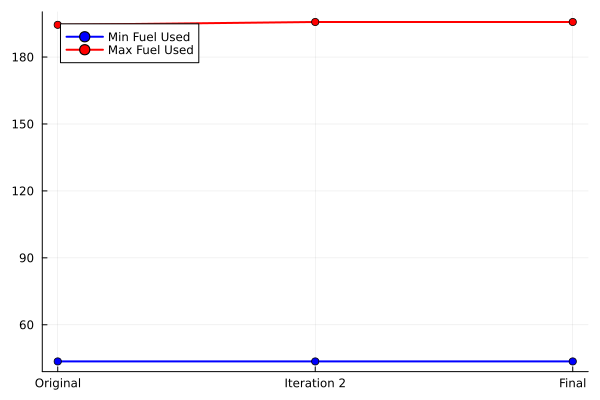

In [16]:
datasets = Dict(
    "Original"    =>   reliability_results,
    "Iteration 2" =>   reliability_results2,
    "Final"       =>   reliability_results_final
)

# Compute descriptive statistics for each dataset
descriptive_statistics_all = Dict(
    name => Dict(
        key =>   isa(value, Vector{Float64}) ? descriptive_stats(value) : value
        for (key, value) in dataset
    )
    for (name, dataset) in datasets
)

println("Descriptive Statistics:")
println(descriptive_statistics_all)

open("./results/stats.json", "w") do f
    write(f, JSON.json(descriptive_statistics_all))
end

# Function to plot comparison line charts
function compare_lineplots(key)
    # Assuming the key exists in all datasets
    if isa(datasets["Original"][key], Vector{Float64})
        p = plot(
            datasets["Original"][key] .* 100,  # Multiply by 100
            label     =   "Original",
            title     =   key,
            linewidth =   2,
            ylims     =   (0, 115),   # Set y-axis limits
            ylabel    =   "%",        # Label for y-axis
            legend    =   :topright
        )
        plot!(p, datasets["Iteration 2"][key] .* 100, label="Iteration 2", linewidth=2, linestyle=:dash)  # Multiply by 100
        plot!(p, datasets["Final"][key] .* 100, label="Final", linewidth=2, linestyle=:dot)  # Multiply by 100
        savefig("./results/plots/comparison_$(key)_lineplot.png")
    end
end

# Extract unique keys across all datasets (assuming they all have the same keys)
all_keys =   keys(datasets["Original"])

# Plot comparison line charts for each key
for key in all_keys
    compare_lineplots(key)
end

# Plot line chart for min and max fuel used
p_fuel = plot(
    ["Original", "Iteration 2", "Final"],
    [
        datasets["Original"]["min_fuel_used"],
        datasets["Iteration 2"]["min_fuel_used"],
        datasets["Final"]["min_fuel_used"]
    ],
    label     =   "Min Fuel Used",
    color     =   :blue,
    linewidth =   2,
    marker    =   :circle
)
plot!(
    p_fuel,
    ["Original", "Iteration 2", "Final"],
    [
        datasets["Original"]["max_fuel_used"],
        datasets["Iteration 2"]["max_fuel_used"],
        datasets["Final"]["max_fuel_used"]
    ],
    label     =   "Max Fuel Used",
    color     =   :red,
    linewidth =   2,
    marker    =   :circle
)